<a href="https://colab.research.google.com/github/javieramarti-dot/Maching_Learning/blob/main/T2_Javiera_Martinez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2

## Nombre(s):
- Javiera Martínez Rojas

## Bosón de Higgs

En esta tarea trabajaremos con datos simulados del bosón de Higgs (versión simplificada), del desafío de [Kaggle](https://www.kaggle.com/c/higgs-boson/overview). Los archivos son Higgs_features.csv y Higgs_labels.csv. Las etiquetas son 0 (no hay señal de Higgs) y 1 (señal de Higgs). Las features son similares a los vistos en el set que utilizamos en clases, tales como energía faltantes, energía, momentum, rapidez transversal y azimutal, etc. Puede encontrar más detalles [acá](https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf). Note que el set de datos para esta tarea es una versión simplificada.

### Parte 1: Descripción de los datos

Cargue los datos dataframes o arreglos de `numpy`, uno para features y otro para etiquetas

- Identifique cúantes instancias y características hay en el set de datos
- Haga un gráfico de la distribución (histograma) de cada feature en el set de datos, en un sólo gráfico. Agregue una leyenda con las etiquetas (Feature 1, Feature 2....etc.) y fije la transparencia de los histogramas (parámetro alpha) en 0.5 para que se noten mejor. ¿Observa algo inusual en la distribución de alguna de las features? Comente en el impacto de esto para su modelo
- ¿Está balanceadas las etiquetas del set del datos? ¿ Por qué esto es un problema? ¿Qué métrica nos conviene usar?



In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import matplotlib
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline

Partimos importando los datos y viendo que contienen

In [2]:

from google.colab import drive
drive.mount('/content/drive')
features=pd.read_csv('/content/drive/MyDrive/Higgs_features.csv')
labels=pd.read_csv('/content/drive/MyDrive/Higgs_labels.csv')

Mounted at /content/drive


In [3]:
font = {'size'   : 8}
matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=8)
matplotlib.rc('ytick', labelsize=8)
matplotlib.rcParams.update({'figure.autolayout': False})
matplotlib.rcParams['figure.dpi'] = 100

In [4]:
features

,393.3350,79.4600,308.8790,4.0950,1.4030,-1.4110,49.0630,39.4780
0,71.048,29.291,55.602,2.439,1.667,-1.412,22.926,9.486
1,141.450,87.017,72.091,1.472,4.714,1.233,23.591,69.754
2,156.539,39.797,127.933,4.017,1.279,-1.408,21.415,18.222
3,89.639,34.399,66.741,2.934,1.417,-1.377,26.459,8.257
4,103.203,7.979,56.074,1.420,0.476,1.216,57.804,60.140
...,...,...,...,...,...,...,...,...
24994,109.449,58.608,65.599,2.573,1.103,1.201,31.336,29.377
24995,139.483,32.872,96.408,2.439,0.447,1.325,69.421,14.668
24996,78.421,51.766,51.303,2.054,1.225,1.108,26.775,30.509
24997,90.507,70.860,75.535,1.650,1.122,-1.410,45.511,27.279


In [5]:
labels

,0
0,0
1,0
2,0
3,0
4,0
...,...
24994,0
24995,1
24996,0
24997,0


In [6]:
print(features.shape)
print(labels.shape)

(24999, 8)
(24999, 1)


Observamos que el conjunto features contiene 24 999 instancias y 8 características. Además, verificamos que el número de filas es el mismo en features y labels, lo que confirma que cada instancia del conjunto de características tiene una etiqueta correspondiente en labels.

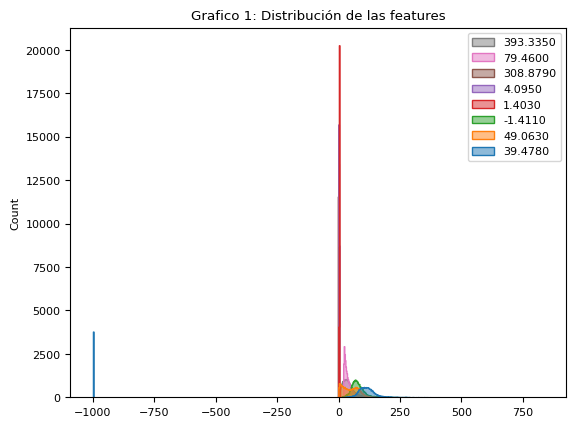

In [7]:
sns.histplot(data=features, element="step", alpha=0.5, common_norm=False)
plt.legend(features.columns)
plt.title("Grafico 1: Distribución de las features")
plt.show()


Notamos que para la variable representada en azul en el gráfico 1 tiene valores negativos lo cual resulta extraño por lo que al buscar en la descripción de las variables encontramos que “ Las variables se indican como “puede estar indefinida” cuando puede ocurrir que carezcan de sentido o no puedan calcularse; en ese caso, su valor es –999.0, el cual está fuera del rango normal de todas las variables.” lo cual concuerda con nuestros valores que se encuentra en -1000. Estos valores “no definidos” pueden causar distorsión en la media, varianza y rango de la variable. Por lo que serán reemplazados  por valores nulos ya que al ser muchos datos (comparado con otras variables) si solo los borramos habría reducido el tamaño de la muestra y podría haber introducido sesgos ya que si se trataba de un caso particular el modelo aprendería de una muestra poco real

Para los demás features, notamos que la mayoría están concentradas en torno a 0, con algunas presentando colas largas o picos pronunciados, por lo que podemos decir que son distribuciones poco uniformes.


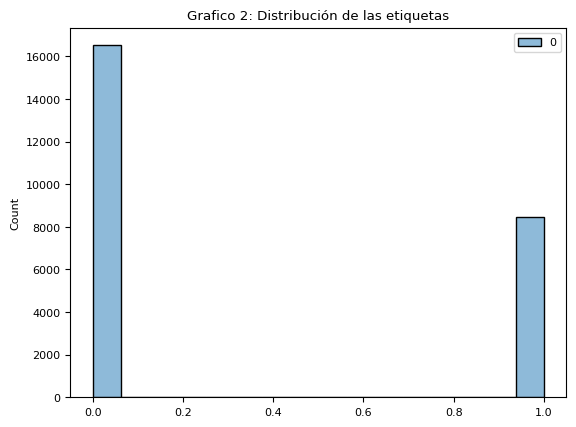

In [8]:
sns.histplot(data=labels, alpha=0.5)
plt.legend(labels.columns)
plt.title("Grafico 2: Distribución de las etiquetas")
plt.show()

Viendo la distribución de las etiquetas en el gráfico 2 notamos que está claramente desbalanceado lo cual tiene todo el sentido ya que detectar el bosón de higgs no es una tarea fácil. Ahora bien para nuestro modelo esto representa un problema porque las métricas como el accuracy pueden ser engañosas ya que nos dirá que el modelo funciona bien pero en realidad está ignorando la clase minoritaria.

Por lo tanto, será mejor usar métricas que consideren el desbalance, como el F1-score, que combina precisión y recall, o bien la curva ROC–AUC para evaluar la capacidad del modelo de distinguir entre ambas clases. Si el objetivo hubiera sido encontrar la mayor cantidad de señales de Higgs posibles la mejor metrica hubiera sido recall.


### Parte 2: Árbol de decisión

- Implemente un clasificador de árbol de decisión con validación cruzada, para una métrica de su elección en base a lo respondido en la pregunta anterior. Reporte el promedio y desviación estándar de los scores obtenidos en los 5 folds.
- Para esta muestra en particular se recomienda usar `StratifiedKFold`. ¿Por qué?
- Genere las etiquetas predichas con `cross_val_predict` y genere la matriz de confusión
- A partir de la matriz de confusión indique los valores de TP, TN, FP, FN. ¿Qué error domina, FP o FN?

Partimos dividiendo el conjunto de datos en los datos de entrenamiento que son el 80%  ( Xtrain y ytrain) y el conjunto de prueba que es 20% que utilizaremos más tarde (Xtest y ytest)

In [9]:
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, random_state=2) #y fijamos la semilla con  random_state=2 para asegurarnos de la reproducibilidad


Se utilizo StratifiedKFold porque, al tratarse de un problema de clasificación desbalanceado, esta técnica garantiza que al dividir los datos en folds se mantiene la misma proporción de clases que en el conjunto original.

In [10]:
cv1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=5) #con shuffle=True mezclamos los datos antes de partirlos

A continuación, se crea el árbol de decisión y se preparan los datos. Utilizando cv1, que divide el conjunto en cinco pliegues, se repite cinco veces el siguiente procedimiento: el modelo se entrena con cuatro pliegues y se evalúa con el restante. En cada una de las cinco iteraciones se calcula la métrica F1-score

In [11]:
model1 = DecisionTreeClassifier(random_state = 1)

In [12]:
scores1= cross_validate(model1, features, labels, cv = cv1, scoring = 'f1')

Finalmente con los 5 resultados obtenidos se calcula el promedio y la desviación estándar

In [13]:
print("{:.3f}".format(scores1['test_score'].mean()), "{:.3f}".format(scores1['test_score'].std()))

0.634 0.002


El modelo tiene un F1-Score promedio de 63.4% lo que nos indica que tenemos un balance entre Precisión y Recall. Con esto podemos decir que está encontrando aproximadamente el 63% de las señales de Higgs (recall) y cuando dice que encontró una señal, acierta el 63% de las veces (precisión). Por otro lado tenemos una desviación estándar de 0.002 lo que indica que el rendimiento del modelo es muy estable y consistente.

Para encontrar la matriz de confucion necesitamos utilizar cross_val_predict que nos permite ver que predijo el modelo para cado dato a diferencia de cross_validate que nos dice que tan bueno es el modelo mediante scores. Con las predicciones podemos comparar con las etiquetas reales (labels) para construir la matriz de confusión

In [14]:
y1 = cross_val_predict(model1, features, labels, cv = cv1) # etiquetas predichas

In [15]:
metrics.confusion_matrix(labels,y1) #matriz de confusion

array([[13330,  3195],
       [ 3054,  5420]])

Tenemos 13.330 (TN) lo que indica que el modelo es bueno identificando que no hay Bosón de Higgs. También tenemos que el modelo encontró correctamente 5.420 (TP) señales del Bosón. Por otro lado hubo 3,054 casos en los que una señal real del Bosón de Higgs estaba presente, pero el modelo no la vio (FN), Finalmente hubo 3,195 casos en los que el modelo encontró una señal, pero en realidad no había nada (FP) y este es el error que predomina por poco.

### Parte 3: SVMs

- Ahora usemos un clasificador usando SVM. Usando SVC, deje los parámetros del clasificador los que viene por defecto y haga una validación cruzada con k=5 y reporte los scores, como hizo antes con el árbol de decisión. ¿Qué algoritmo tiene mejor performance?
Nota: SVMs es un algoritmo lento y puede tomar tiempo este cálculo. Si toma demasiado tiempo, reduzca el número de folds (no menos de 3).
- Reporte la matriz de confusión para SVC. Hay algún cambio de los valores de FP y FN respecto al modelo de árbol de decisión?

Partimos con el modelo svc con random_state para que los resultados sean reproducibles

In [64]:
model_svc = SVC(random_state=1)

Luego entrenamos el modelo varias veces utilizando diferentes particiones generadas por la validación cruzada, y evaluamos su desempeño mediante la métrica F1-score, buscando que el modelo la maximice.

In [65]:
scores2= cross_validate(model_svc, features, labels, cv = cv1, scoring = 'f1') #se demora 1 min 27 s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

Se presenta el promedio y la desviacion estandar

In [66]:
print("{:.3f}".format(scores2['test_score'].mean()), "{:.3f}".format(scores2['test_score'].std()))

0.663 0.004


Aquí notamos que comparación del inciso anterior este modelo presenta un promedio del F1 score más alto, pero una desviación estándar más alta


utilizamos cross_val_predict para construir la matriz de confusión

In [67]:
y2 = cross_val_predict(model_svc, features, labels, cv = cv1) # etiquetas predichas se demora 1 min 20 s

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for exam

In [68]:
metrics.confusion_matrix(labels,y2) #matriz de confusion

array([[14578,  1947],
       [ 3303,  5171]])

De la matriz vemos que el modelo predijo que había bosón y efectivamente sí había en 5171 casos (TP).El modelo acertó diciendo que 'no había señal' en 14578 casos (TN).Luego, en el caso donde predijo que había señal pero realmente no había, fueron 1947 casos (FP). Finalmente, hubo 3303 casos en los que el modelo dijo que 'no había señal', pero en realidad sí había una (FN). Este es el error más problemático, ya que son las señales que el modelo no pudo encontrar.

Al comparar este modelo con el anterior, observamos que tiene un mejor desempeño al detectar los casos en los que no hay bosón, es decir, presenta un mayor número de verdaderos negativos (TN).Por otro lado, su capacidad para identificar correctamente los casos en los que sí hay bosón es inferior, ya que el modelo previo alcanzaba 5 420 verdaderos positivos (TP).Además, este modelo comete más errores al predecir que no hay señal cuando en realidad sí la hay, superando los 3 054 falsos negativos (FN) del modelo anterior.Finalmente, en los casos donde el modelo detecta una señal inexistente (FP), el desempeño mejora, ya que este valor resulta menor que los 3 195 obtenidos previamente.

### Parte 4: optimización de hiperparámetros

- Intente optimizar los parámetros de SVC. Para evitar que tome demasiado tiempo, seleccione solo el primer 5% de los datos (asegúrese de desordenarlos antes)
- Haga un esquema de CV con GridSearch, con los siguientes valores de parámetros:
parameters = {'kernel':['linear','rbf'],'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5], 'class_weight':[{1:1},{1:3},{1:5}]}
- Recuerde seguir usando la métrica que eligió más arriba.
- Esto tomará tiempo! Fije verbose=2 en GridSearch para monitorear el progreso, y njobs=4 o más para acelerar un poco el proceso.
- Reporte los parámetros y scores del mejor modelo

Partimos mezclando los datos y separamos el 5% de ellos

In [86]:
features_mesclados, labels_mesclados = shuffle(features, labels, random_state=2)

In [87]:
largo_features = len(features_mesclados)
features_5 = int(largo_features * 0.05)
largo_labels = len(labels_mesclados)
labels_5 = int(largo_labels * 0.05)
features5 = features_mesclados[:features_5]# 5% de los features
labels5 = labels_mesclados[:labels_5]# 5% de los labels

Primero utilice make_pipeline que me lo recomendo una IA ya que intente hacerlo sin esto solo con los parámetros que entregaba la tarea y usando este código:

model_svc = SVC(random_state=1)

parameters = {'kernel':['linear','rbf'],'C':[1, 10, 100], 'gamma':[0.01, 0.1, 0.5], 'class_weight':[{1:1},{1:3},{1:5}]}

model = GridSearchCV(model_svc, parameters, cv=StratifiedKFold(n_splits=3, shuffle=True),scoring='f1', verbose=2, n_jobs=4, return_train_score=True)

model.fit(features5, labels5)

pero nunca terminaba de correr, de hecho esperé como media hora y no funcionó así que decidí cambiar. Con make_pipeline lo que hace es que le dice a scikit-learn que debe ejecutar los pasos en orden, primero con StandardScaler escala los datos, por lo que estuve leyendo esto ayuda a a SVC ya que este es muy sensible a la escala y luego con estos datos escalados se lo pasa al modelo SCV para que lo entrene

In [101]:
piped_model = make_pipeline(StandardScaler(), SVC())

In [102]:
parameters = {'svc__kernel': ['linear', 'rbf'], 'svc__C': [1, 10, 100], 'svc__gamma': [0.01, 0.1, 0.5], 'svc__class_weight': [{1:1}, {1:3}, {1:5}] }

In [103]:
model = GridSearchCV(piped_model, parameters, cv=StratifiedKFold(n_splits=5, shuffle=True),scoring='f1', verbose=2, n_jobs=4, return_train_score=True)

In [104]:
model.fit(features5, labels5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC())]),
             n_jobs=4,
             param_grid={'svc__C': [1, 10, 100],
                         'svc__class_weight': [{1: 1}, {1: 3}, {1: 5}],
                         'svc__gamma': [0.01, 0.1, 0.5],
                         'svc__kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='f1', verbose=2)

In [96]:
print(f"La mejor combinación de parámetros es:")
print(model.best_params_)
print(f"El mejor score fue:")
print(f"{model.best_score_}")

La mejor combinación de parámetros es:
{'svc__C': 10, 'svc__class_weight': {1: 1}, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
El mejor score fue:
0.6912101553065407


### Parte 5: clases imbalanceadas
- Existen muchas estrategias para manejar clases imbalanceadas... (De hecho, en el paso anterior aplicamos una, puede decir cuál es?). Investigue o piense una solución para el desbalance, impleméntela para SVC con los parámetros optimizados, y comente su resultado, compare con el anterior

Para el caso anterior la estrategia para combatir el desbalance fue class_weight':[{1:1},{1:3},{1:5}] que nos permitio ajustar la importancia de cada clase para que el algoritmo preste mayor atención a la clase minoritaria. Al darle los valores {1:1}, {1:3} y {1:5}, el modelo considera que cometer un error en la clase 1 es igual, tres o cinco veces peor que equivocarse en la clase 0. Así, al aplicar GridSearchCV, no solo se buscan los mejores hiperparámetros, sino que también se penaliza al modelo por cometer errores en la clase menos representada.

Leyendo del class_weight encontré que se podía usar ´balance´ que lo que hace  es que ajusta automáticamente el peso de cada clase según su frecuencia por lo que es muy parecido a lo que teníamos antes pero esta vez al depender de la frecuencia los errores cometidos en la clase minoritaria son penalizados con mayor severidad que aquellos en la clase mayoritaria.

In [113]:
svc_balanced = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, gamma=0.1, class_weight='balanced'))

print(f"F1-score= {f1_score(labels5, y_pred_balanced):.4f}")


F1-score= 0.7054


Con este ajuste pudimos mejorar la puntuación de la métrica, lo que indica que el modelo tuvo un mejor desempeño.

### Parte 6: Conclusiones

- En base a sus resultados, cuál algoritmo de clasificación recomendaría para este problema?
- ¿Qué otras consideraciones o limitaciones tenemos?

En base a los resultados, el algoritmo que recomendaría es GridSearchCV con la opción class_weight='balanced', ya que fue el que obtuvo el mejor valor de F1-score.

Las principales limitaciones de este modelo se deben al tamaño del conjunto de datos. Dado que la cantidad de muestras es muy grande, la prueba se realizó solo con una parte de ellas, lo que implica que los resultados no representan completamente la realidad. Además, si se hubiese trabajado con la totalidad de los datos, el proceso habría requerido un tiempo de ejecución excesivo. Por ello, aunque el modelo presenta una buena métrica, aún se encuentra poco optimizado.

Aun así, elegí este modelo porque los datos que maneja son complejos y, en este caso, la precisión al detectar correctamente la presencia del bosón de Higgs resulta mucho más relevante que la optimización del tiempo de cómputo. En contextos científicos, los errores de clasificación pueden tener consecuencias significativas, por lo que es preferible priorizar la calidad y confiabilidad de las predicciones por sobre la velocidad del entrenamiento.

 Además, es importante considerar algunos aspectos adicionales. El modelo SVC es altamente sensible a la escala de los datos, por lo que fue necesario aplicar un proceso de normalización con StandardScaler() antes del entrenamiento. Por otro lado, F1-score busca un equilibrio entre precision y recall, pero si el objetivo principal fuera detectar todos los eventos de bosón de Higgs, podría haberse priorizado el recall como métrica principal.